In [1]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install tensorflow

In [2]:
import tensorflow as tf
import keras
from tensorflow.keras import datasets, layers, models  
import numpy as np  
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from PIL import Image
from skimage.transform import resize, rotate

# Load LIDC dataset
### Step 1: Load all nodules as a 3D representation in numpy array & the labels from the nodule name

In [3]:
# Select an even number of slices to extract:
num_slices = 6
# Select nodules dataset location
lidc_path = Path('F:\\master\\manifest-1600709154662\\nodules_16slices')

In [4]:
images = []
diagnostics = []
nodules_path = list(lidc_path.iterdir())
for nodule_path in nodules_path:
    images_path = list(nodule_path.iterdir())
    # Reduce the slices to the specified amount:
    images_path = images_path[int(len(images_path)/2)-int(num_slices/2):int(len(images_path)/2)+int(num_slices/2)]
    # Merge all slices of a nodule together --> create 3D representation of the nodule
    image_nodule = []
    for image_path in images_path:
        # Load slice image
        image_slice = np.array(Image.open(image_path)) / 255.0
        # Add it to the nodule
        image_nodule.append(image_slice)
    # convert the 3D nodule to numpy array
    image_nodule = np.array(image_nodule)
    
    diag = int(nodule_path.name.split('_')[5])
    # remove incorrect image shape or diagnostic incogruent
    if image_nodule.shape == (num_slices, 64, 64) and diag != 3:
        # Add the nodule 3D representation to the list of images
        images.append(image_nodule)
        # Save nodule label (diagnostic)
        diagnostics.append(diag)
    elif image_nodule.shape != (num_slices, 64, 64):
        print(f'[ERROR] {nodule_path.name} has shape {image_nodule.shape}, but expected shape is: (16, 64, 64)')
# convert the dataset to numpy array
images = np.array(images)

[ERROR] patient_462_nod_1_diag_2 has shape (6, 64, 54), but expected shape is: (16, 64, 64)
[ERROR] patient_463_nod_1_diag_2 has shape (6, 64, 54), but expected shape is: (16, 64, 64)
[ERROR] patient_655_nod_3_diag_2 has shape (6, 64, 57), but expected shape is: (16, 64, 64)
[ERROR] patient_997_nod_2_diag_1 has shape (6, 64, 55), but expected shape is: (16, 64, 64)


#### Visualize data

In [5]:
from collections import Counter
import pandas

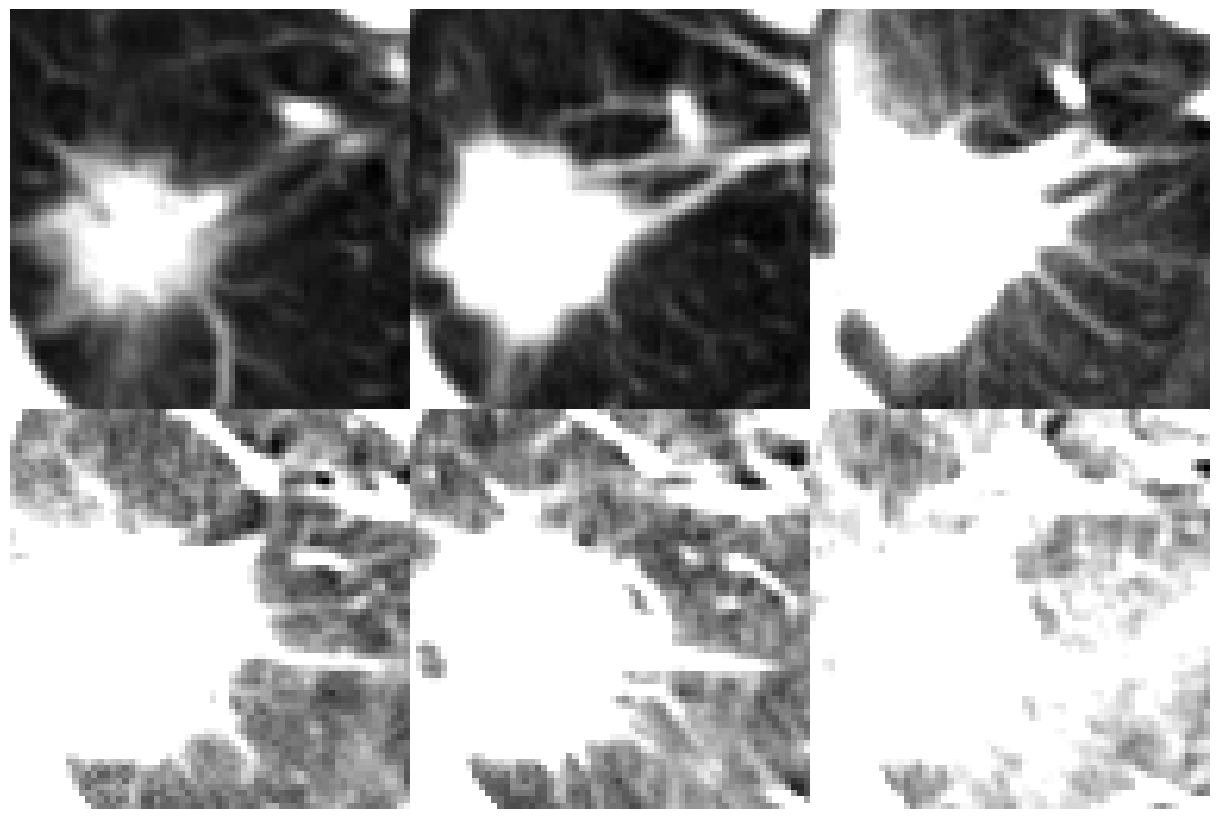

In [6]:
def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of X CT slices"""
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i, j], cmap="gray")  # Corrected indexing
            #axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()


# Visualize montage of slices.
plot_slices(
    num_rows=2, 
    num_columns=3, 
    width=64, 
    height=64, 
    data=images[0].transpose()
)

### Ste 2: Simplify labels
The label is a subjective assessment of the likelihood of malignancy of the given nodule, assuming the scan originated from a 60-year-old male smoker.

The original label system has 5 labels:

1: ‘Highly Unlikely’

2: ‘Moderately Unlikely’

3: ‘Indeterminate’

4: ‘Moderately Suspicious’

5: ‘Highly Suspicious’

It has been simplified to a binary clasification system, being:

0: if original label < 3 (benign)

1: if original label > 3 (malign)

In [7]:
# Simplify label system
labels = [0 if label<3 else 1 for label in diagnostics]
labels = np.array(labels)

<Axes: >

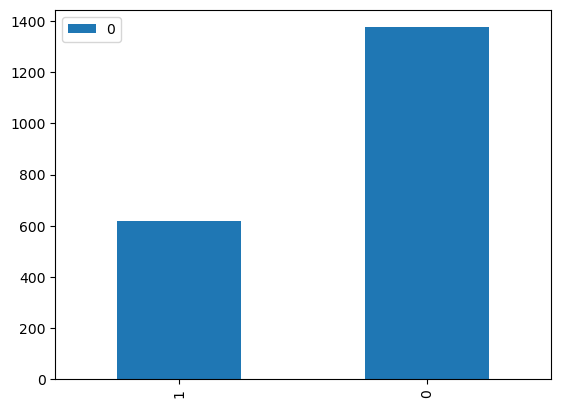

In [8]:
count = Counter(labels)
df = pandas.DataFrame.from_dict(count, orient='index')
df.plot(kind='bar')

Divide between train and test data

In [9]:
# Create train and test dataset
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.33, random_state=42)

# Building the CNN:
Models used by others: https://github.com/marichka-dobko/Lung_Nodule_Classification/blob/master/src_keras/models_keras.py

A simple CNN with 5 convolutional layers

In [31]:
def le_net_3d():
    model = keras.Sequential()
    model.add(layers.Convolution3D(6, kernel_size=(1, 5, 5), activation='relu', input_shape=(6,64,64,1)))
    model.add(layers.MaxPooling3D(strides=2)) 
    model.add(layers.Convolution3D(16, kernel_size=(1, 5, 5), activation='relu'))
    model.add(layers.MaxPooling3D(strides=2)) 

    model.add(layers.Flatten())
    model.add(layers.Dense(120, activation='relu'))
    model.add(layers.Dense(84, activation='relu'))
    model.add(layers.Dense(2, activation='softmax'))

    return model


# Build model.
model = le_net_3d()
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           (None, 6, 60, 60, 6)      156       
                                                                 
 max_pooling3d_6 (MaxPoolin  (None, 3, 30, 30, 6)      0         
 g3D)                                                            
                                                                 
 conv3d_7 (Conv3D)           (None, 3, 26, 26, 16)     2416      
                                                                 
 max_pooling3d_7 (MaxPoolin  (None, 1, 13, 13, 16)     0         
 g3D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 2704)              0         
                                                                 
 dense_9 (Dense)             (None, 120)              

We can then compile and train our model.

Epoch 1/15
42/42 [==============================] - 3s 58ms/step - loss: 0.6032 - accuracy: 0.6921 - val_loss: 0.5572 - val_accuracy: 0.7284
Epoch 2/15
42/42 [==============================] - 2s 50ms/step - loss: 0.5122 - accuracy: 0.7506 - val_loss: 0.5228 - val_accuracy: 0.7223
Epoch 3/15
42/42 [==============================] - 2s 52ms/step - loss: 0.4688 - accuracy: 0.7745 - val_loss: 0.5195 - val_accuracy: 0.7299
Epoch 4/15
42/42 [==============================] - 2s 50ms/step - loss: 0.4288 - accuracy: 0.7985 - val_loss: 0.4892 - val_accuracy: 0.7633
Epoch 5/15
42/42 [==============================] - 2s 47ms/step - loss: 0.3886 - accuracy: 0.8187 - val_loss: 0.5583 - val_accuracy: 0.7117
Epoch 6/15
42/42 [==============================] - 2s 50ms/step - loss: 0.3457 - accuracy: 0.8509 - val_loss: 0.5281 - val_accuracy: 0.7557
Epoch 7/15
42/42 [==============================] - 2s 53ms/step - loss: 0.2993 - accuracy: 0.8734 - val_loss: 0.5070 - val_accuracy: 0.7602
Epoch 8/15
42

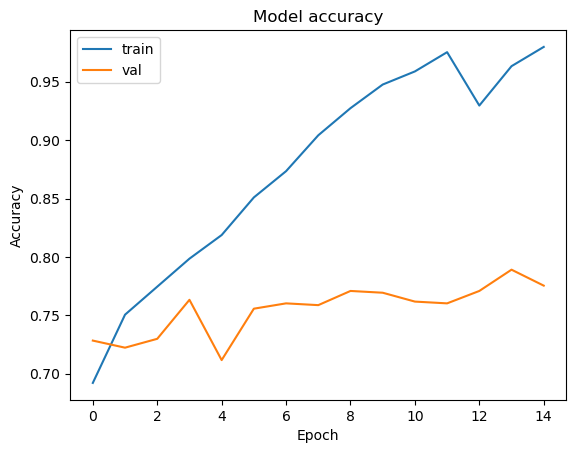

Training accuracy: 0.9797753095626831
Validation accuracy: 0.7754173278808594


In [32]:
def fit_model(model, epochs):  
    model.compile(  
        optimizer="adam",  
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  
        metrics=["accuracy"],  
    )  

    history = model.fit(  
        train_images,  
        train_labels,  
        epochs=epochs,  
        validation_data=(test_images, test_labels),  
    )
    
    # Plot training history
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    # Plot final model accuracy
    print(f'Training accuracy: {history.history["accuracy"][-1]}')
    print(f'Validation accuracy: {history.history["val_accuracy"][-1]}')
    return model


model = fit_model(model, epochs=15)

Now, let’s see how this model handles out-of-distribution data. Imagine we deploy this model to recognize digits, but users sometimes fail to write down the entire digit. What happens when users do not write down the entire digit? We can get an answer to this question by gradually removing more and more information from a digit, and seeing how our model handles the perturbed inputs. We can define our function to remove signal as follows:

In [33]:
def remove_signal(img: np.ndarray, slice_index: int) -> np.ndarray:  
    img = img.copy()  
    img[slice_index, :, :] = 0  # Set the specified slice to black
    return img

And then we perturb our images:

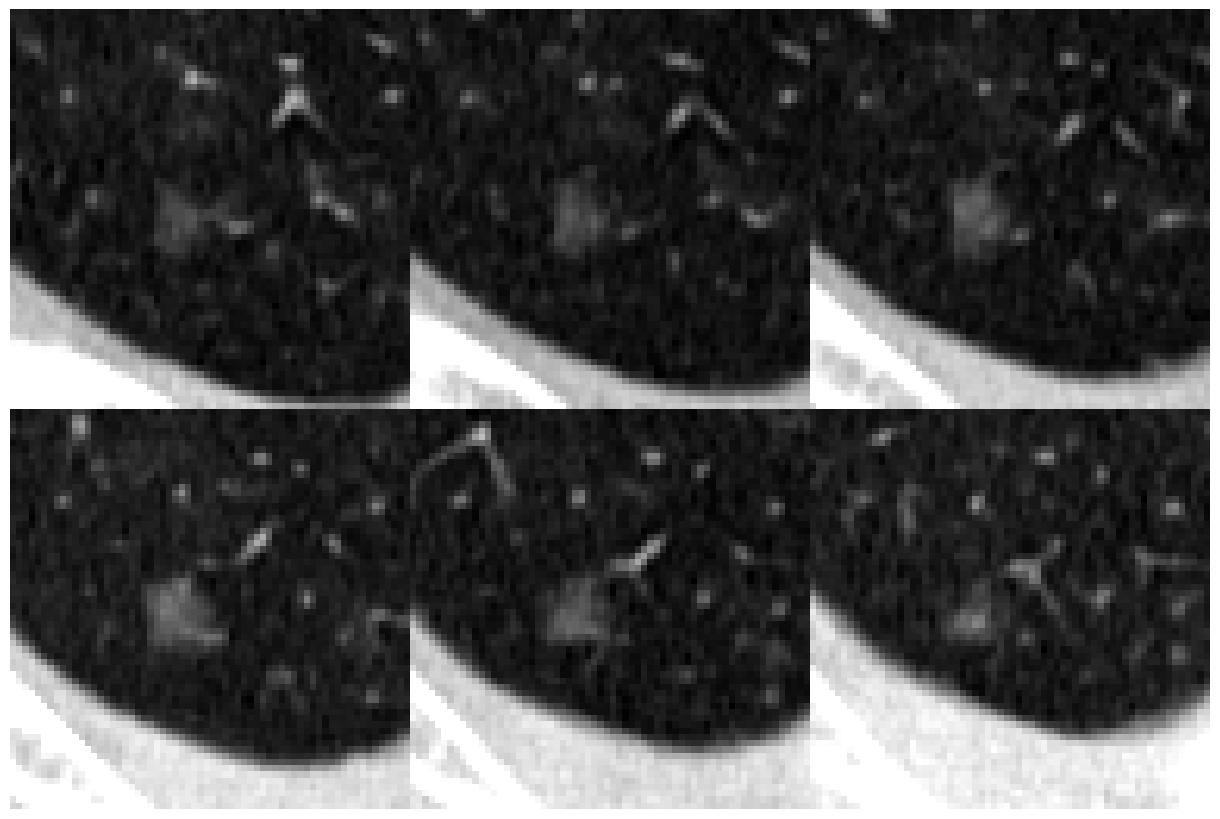

In [34]:
img = test_images[0]
img_label = test_labels[0]
# Visualize montage of slices.
plot_slices(
    num_rows=2, 
    num_columns=3, 
    width=64, 
    height=64, 
    data=img.transpose()
)

In [35]:
imgs = []
img_perturbed = img
for i in range(0, 16):  
   img_perturbed = remove_signal(img_perturbed, i)  
   if np.array_equal(img, img_perturbed):  
     continue  
   imgs.append(img_perturbed)  
   if img_perturbed.sum() == 0:  
     break

We only add perturbed images to our list of images if setting a row to 0 actually changes the original image ( if np.array_equal(img, img_perturbed)) and stop once the image is completely black, meaning it just contains pixels with a value of 0. We run inference on these images:

In [36]:
softmax_predictions = tf.nn.softmax(model(np.expand_dims(imgs, -1)), axis=1)

We can then plot all images with their predicted labels and confidence scores:

Ground truth: 0
0 - 73.10%


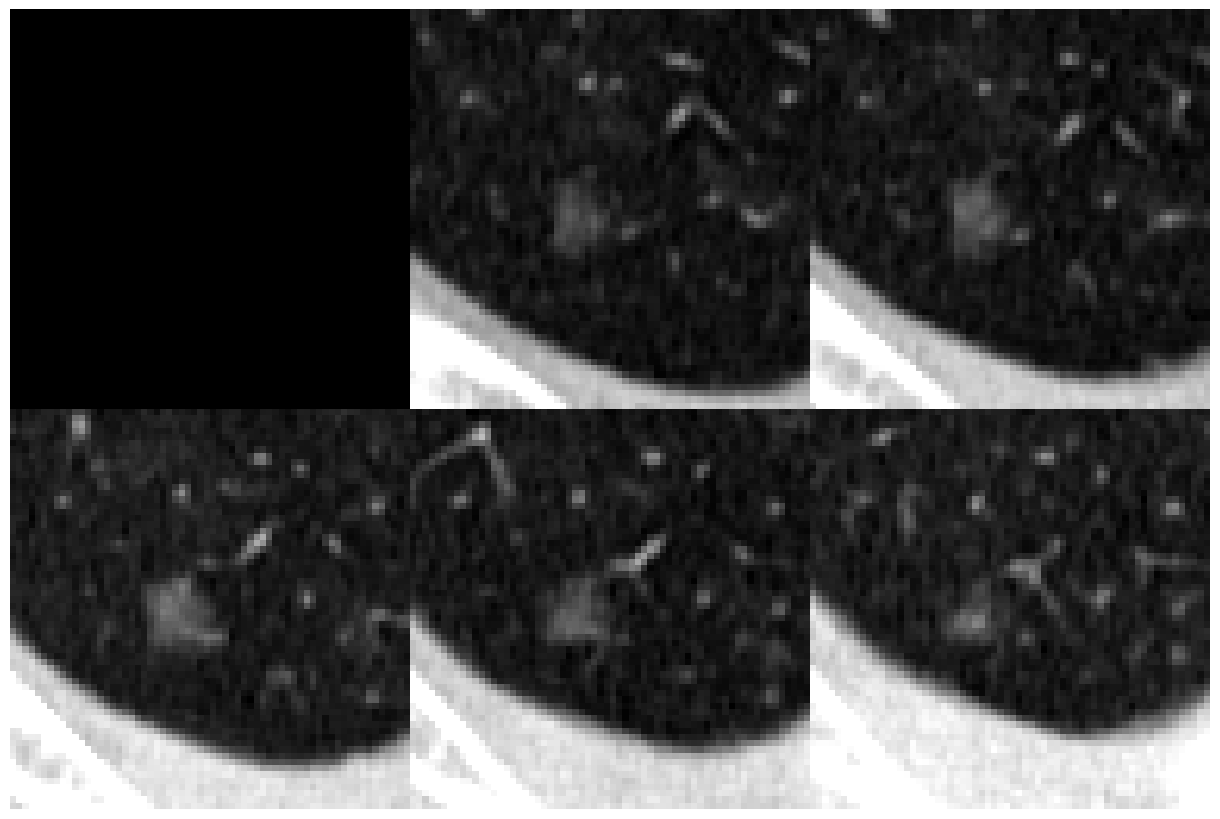

0 - 73.07%


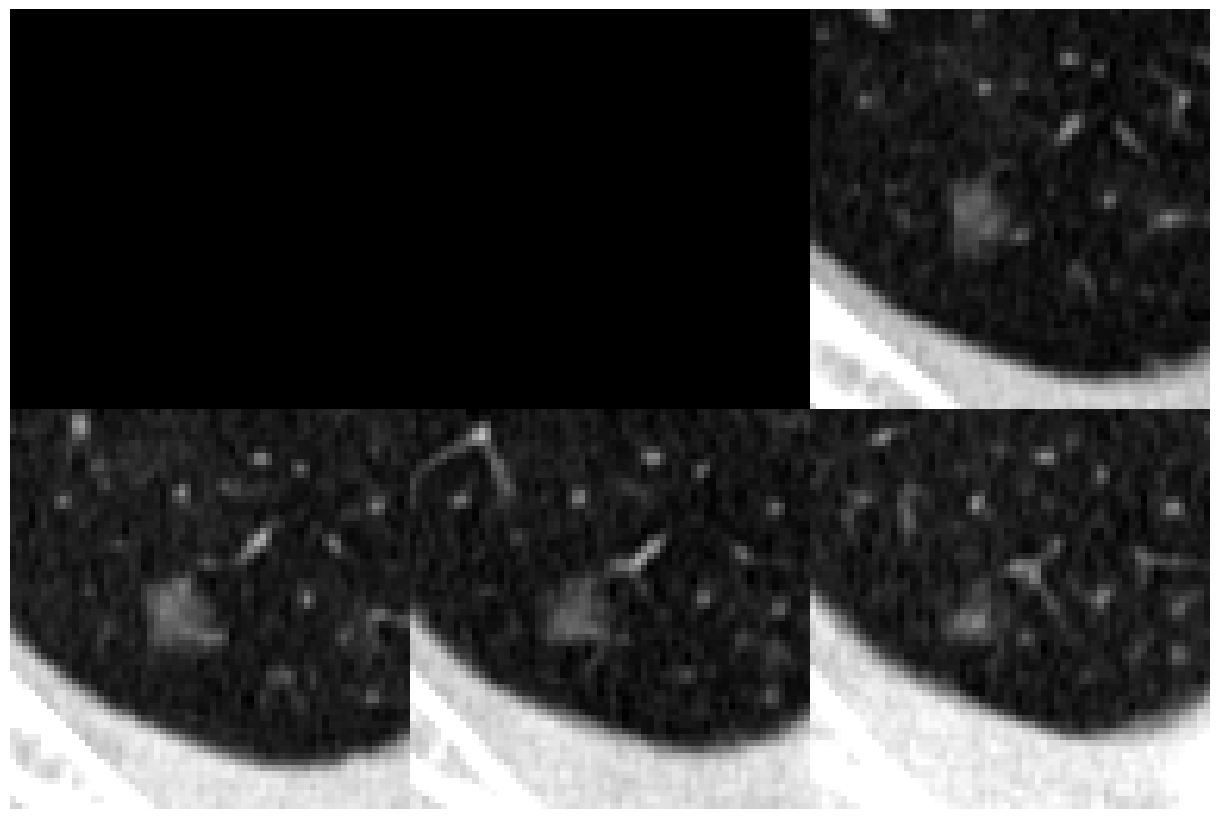

0 - 73.03%


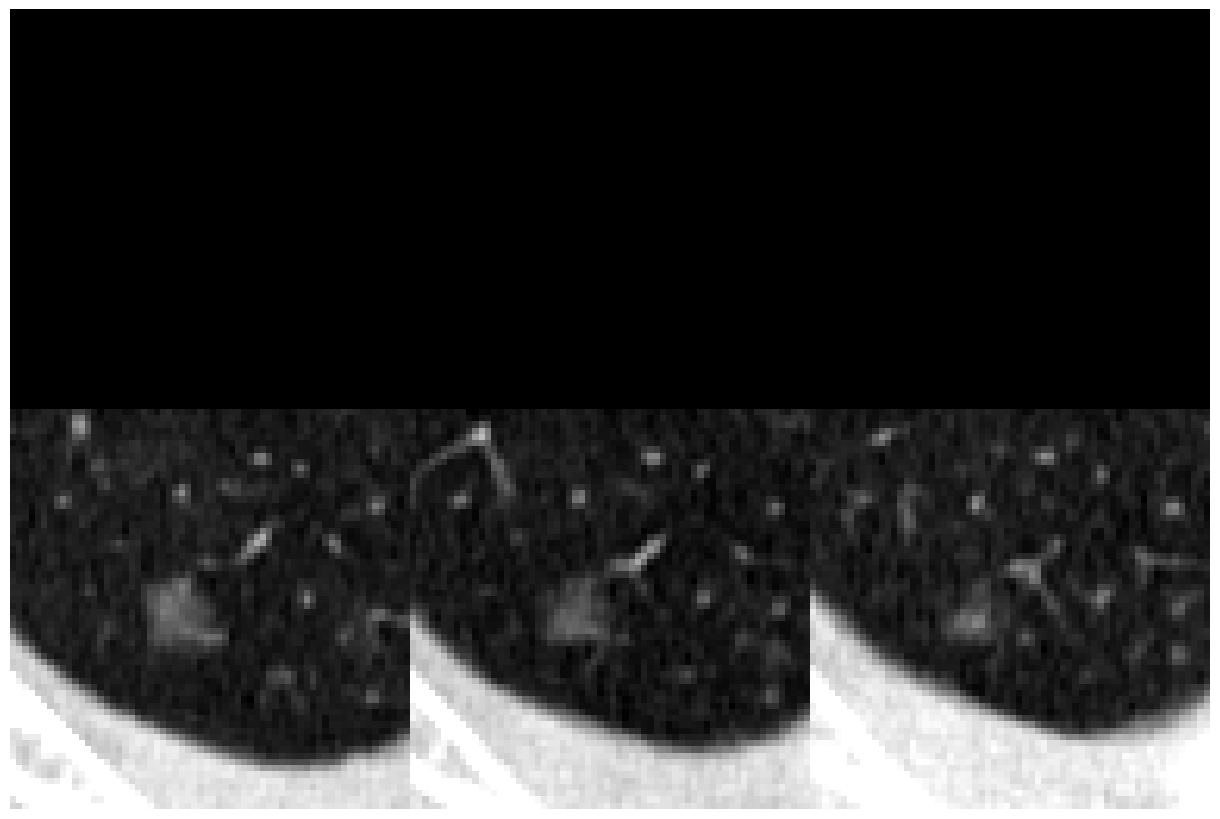

0 - 61.08%


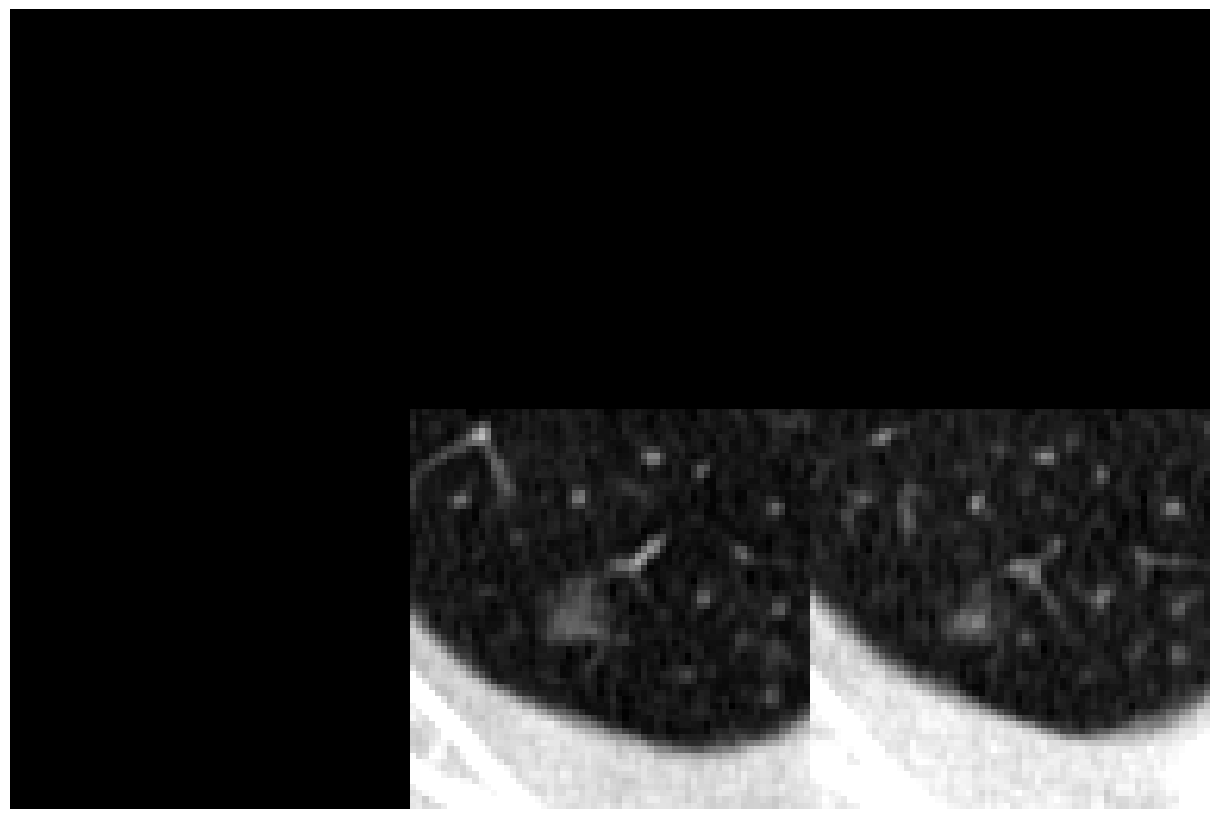

0 - 61.08%


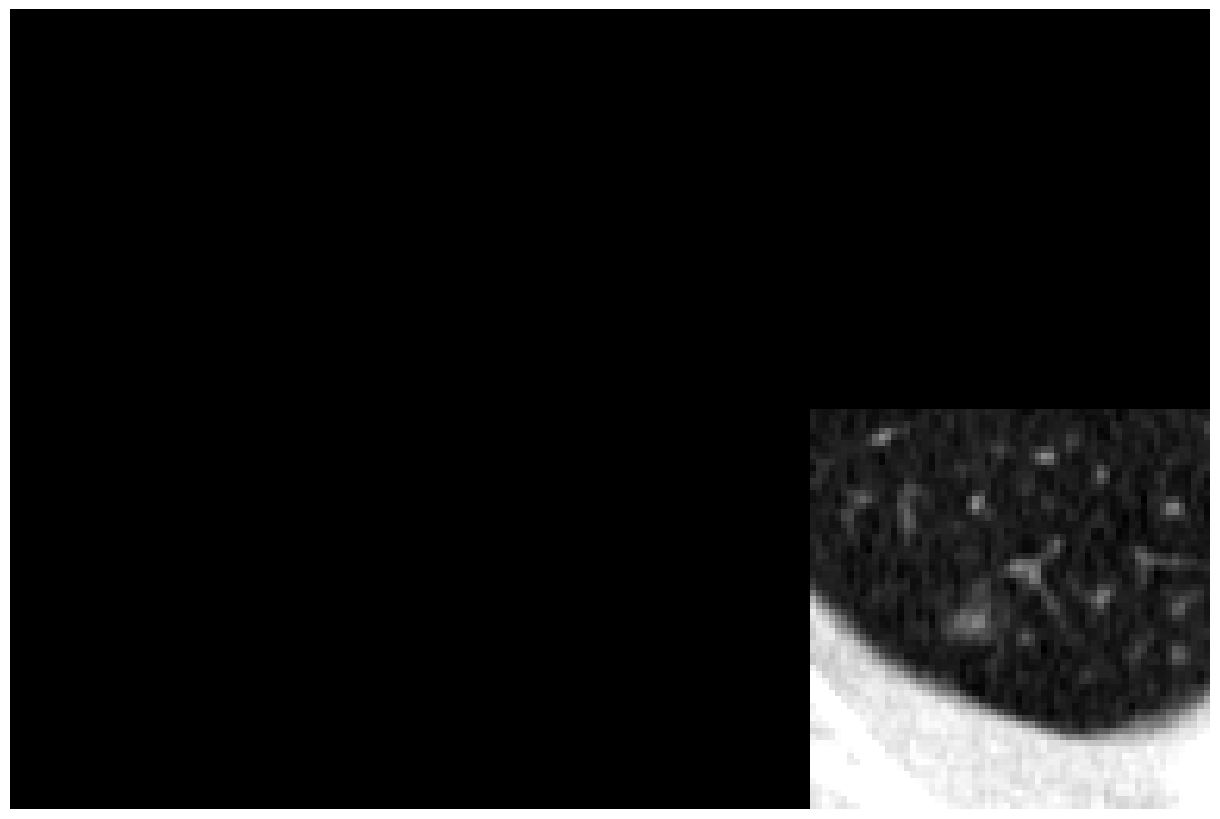

0 - 61.08%


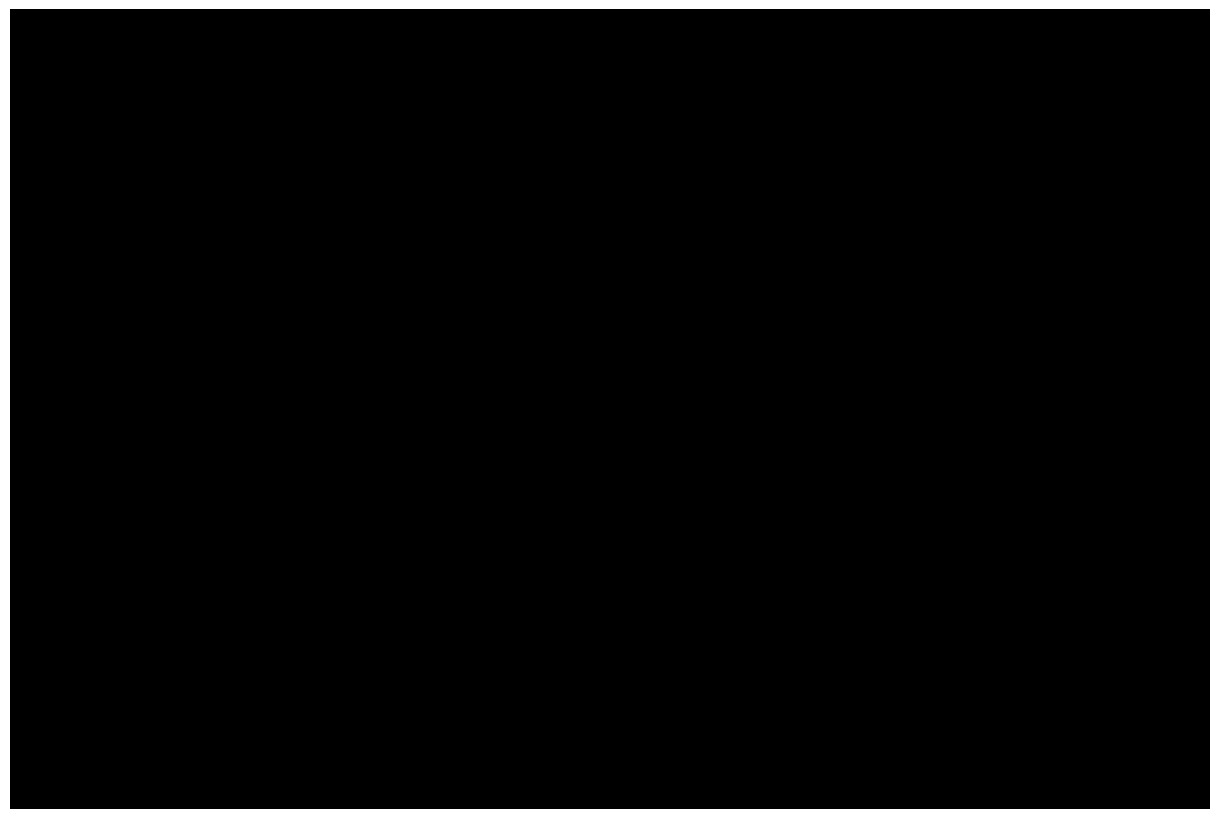

In [37]:
print(f'Ground truth: {img_label}')

for i in range(len(imgs)):  
  
    certainity = softmax_predictions[i].numpy().max()  
    label = np.argmax(softmax_predictions[i])  
    print(f"{label} - {certainity:.2%}")
    plot_slices(
    num_rows=2, 
    num_columns=3, 
    width=64, 
    height=64, 
    data=imgs[i].transpose()
)

Let’s see what a slightly different model would predict on these images. We’ll now use MC dropout as our model. By sampling, we should be able to increase the models’ uncertainty compared to a standard NN. 

Let’s first define our model:

In [38]:
def le_net_3d_dropout():
    model = keras.Sequential()
    model.add(layers.Convolution3D(6, kernel_size=(1, 5, 5), activation='relu', input_shape=(6,64,64,1)))
    
    model.add(layers.Dropout(0.2))
    model.add(layers.MaxPooling3D(strides=2)) 
    model.add(layers.Convolution3D(16, kernel_size=(1, 5, 5), activation='relu'))
    model.add(layers.MaxPooling3D(strides=2))
    
    model.add(layers.Dropout(0.5))
    model.add(layers.Flatten())
    model.add(layers.Dense(120, activation='relu'))
    
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(84, activation='relu'))
    
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(2, activation='softmax'))

    return model

Then let’s instantiate it:

Epoch 1/15
42/42 [==============================] - 7s 130ms/step - loss: 0.6560 - accuracy: 0.6659 - val_loss: 0.5984 - val_accuracy: 0.7041
Epoch 2/15
42/42 [==============================] - 5s 125ms/step - loss: 0.5932 - accuracy: 0.6854 - val_loss: 0.5463 - val_accuracy: 0.7056
Epoch 3/15
42/42 [==============================] - 6s 137ms/step - loss: 0.5467 - accuracy: 0.7273 - val_loss: 0.5226 - val_accuracy: 0.7466
Epoch 4/15
42/42 [==============================] - 5s 125ms/step - loss: 0.5169 - accuracy: 0.7453 - val_loss: 0.5076 - val_accuracy: 0.7663
Epoch 5/15
42/42 [==============================] - 5s 123ms/step - loss: 0.4815 - accuracy: 0.7730 - val_loss: 0.4881 - val_accuracy: 0.7572
Epoch 6/15
42/42 [==============================] - 5s 123ms/step - loss: 0.4713 - accuracy: 0.7655 - val_loss: 0.5036 - val_accuracy: 0.7496
Epoch 7/15
42/42 [==============================] - 5s 118ms/step - loss: 0.4533 - accuracy: 0.7753 - val_loss: 0.4810 - val_accuracy: 0.7436
Epoch 

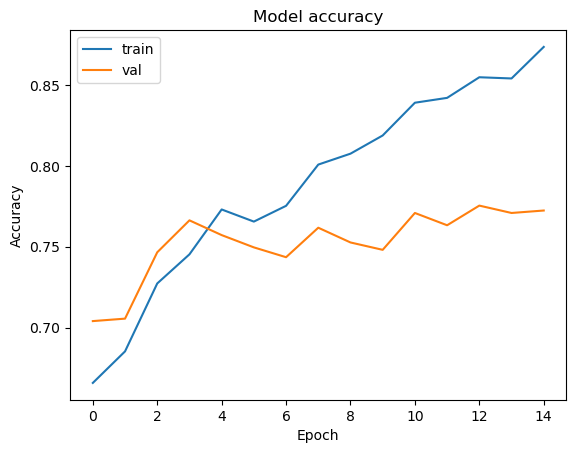

Training accuracy: 0.8734082579612732
Validation accuracy: 0.772382378578186


In [39]:
dropout_model = le_net_3d_dropout()  
dropout_model = fit_model(dropout_model, epochs=15)

Our model with dropout will achieve a similar accuracy as our vanilla model. Let’s now run inference with dropout and plot the mean confidence score of MC dropout:

In [40]:
predictions = np.array(  
    [  
        tf.nn.softmax(dropout_model(np.expand_dims(imgs, -1), training=True), axis=1)  
        for _ in range(100)  
    ]  
)  
predictions_mean = np.mean(predictions, axis=0)  

This again produces a figure showing the predicted labels and their associated confidence scores:

In [41]:
def plot_predictions(predictions, imgs):
    for i in range(len(imgs)):
        certainity = predictions[i].max()  
        label = np.argmax(predictions[i])  
        print(f"{label} - {certainity:.2%}")
        plot_slices(
        num_rows=2, 
        num_columns=3, 
        width=64, 
        height=64, 
        data=imgs[i].transpose()
)

Ground truth: 0
0 - 57.77%


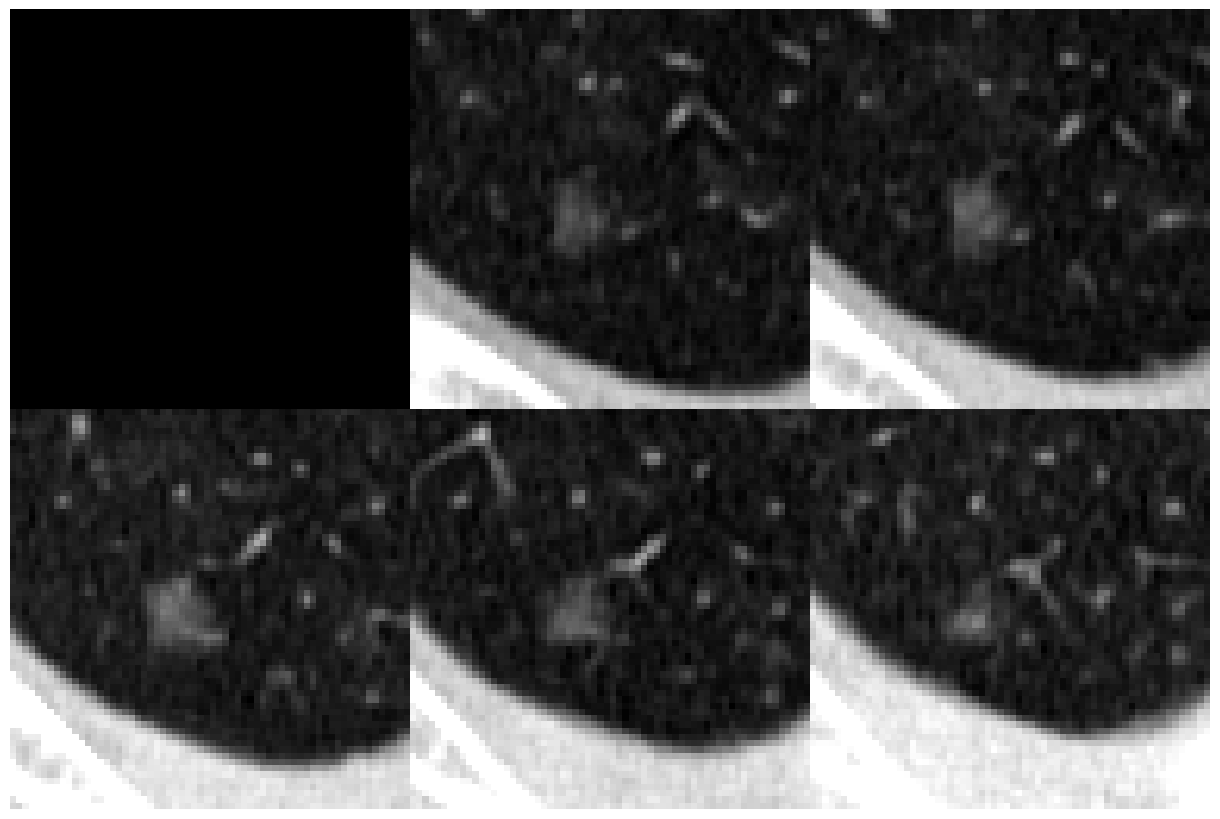

0 - 65.25%


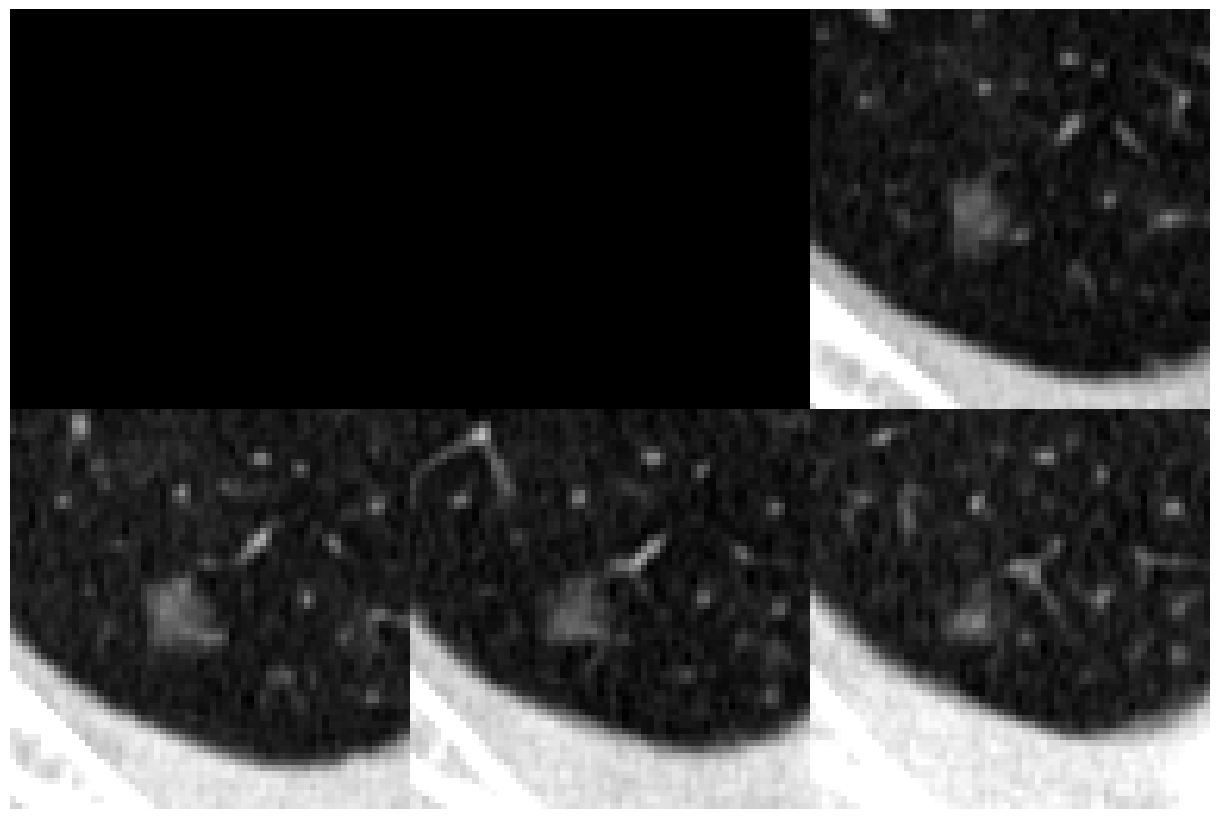

0 - 66.43%


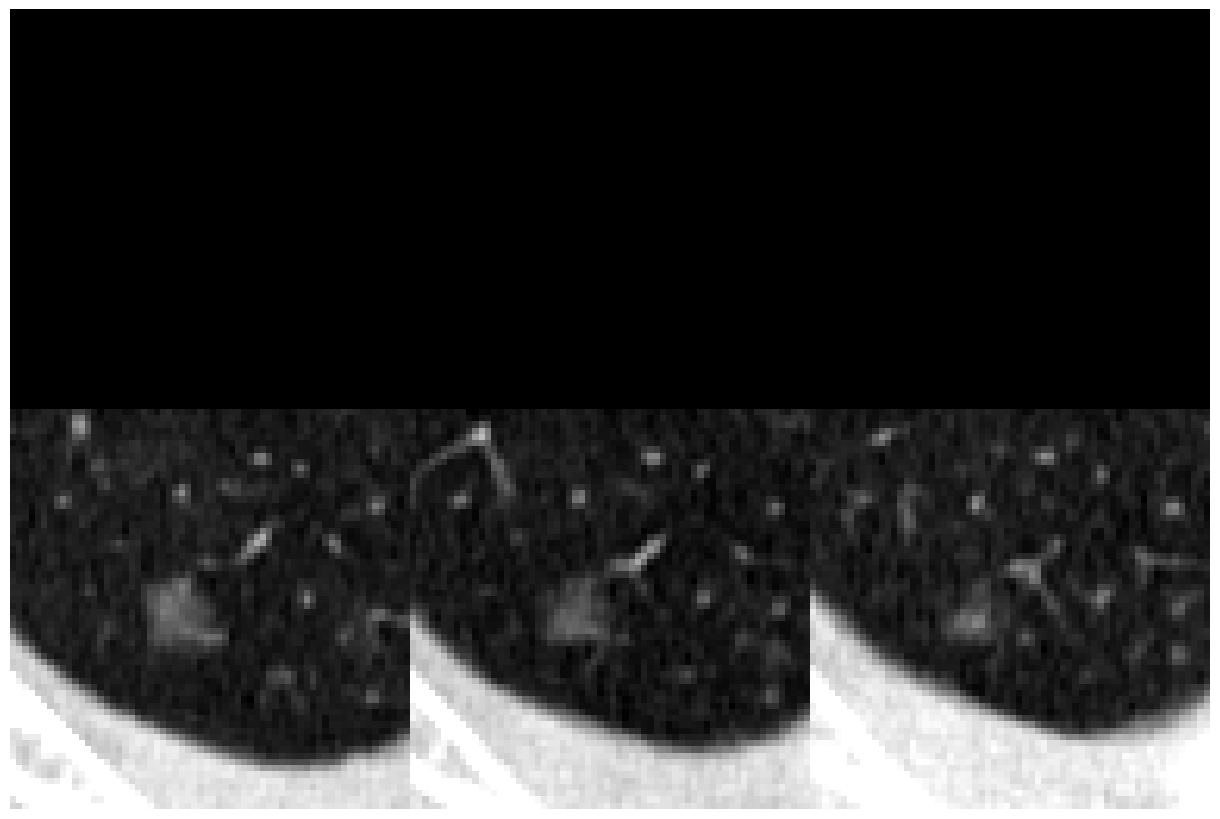

0 - 63.58%


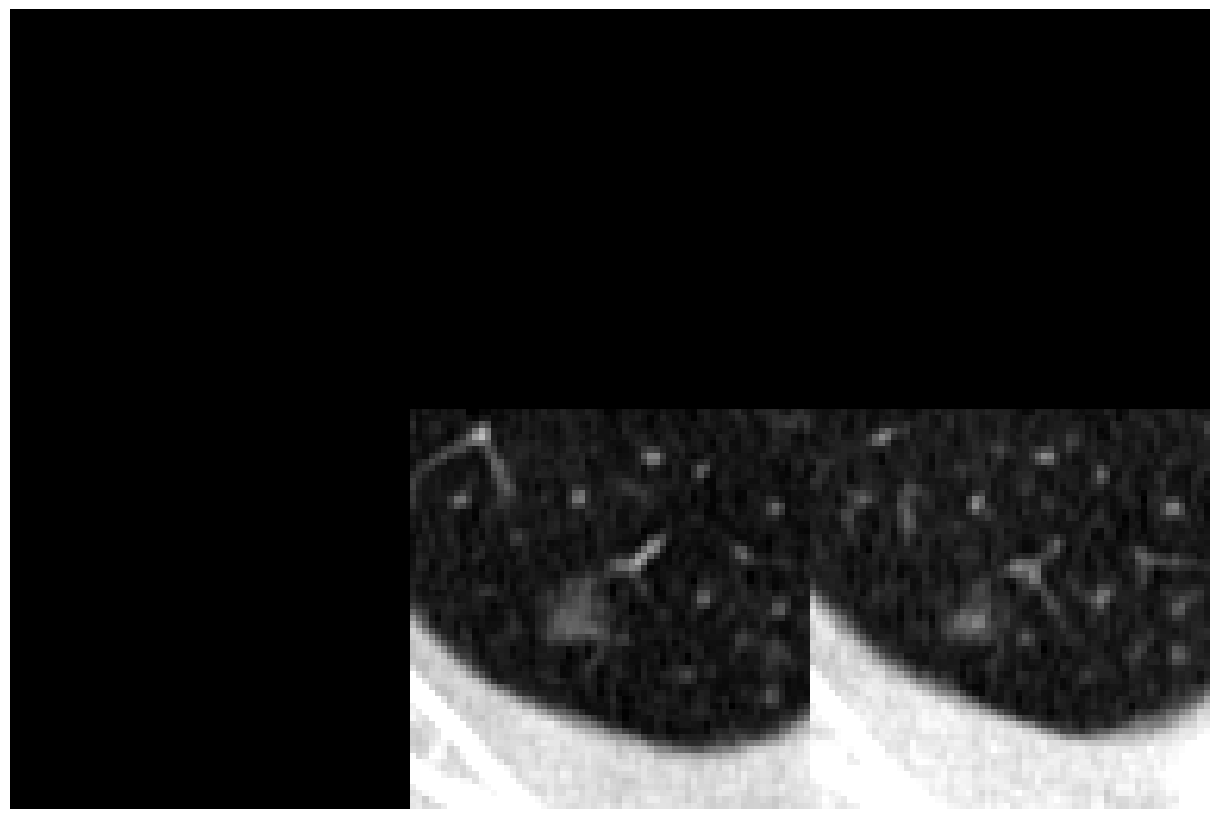

0 - 62.89%


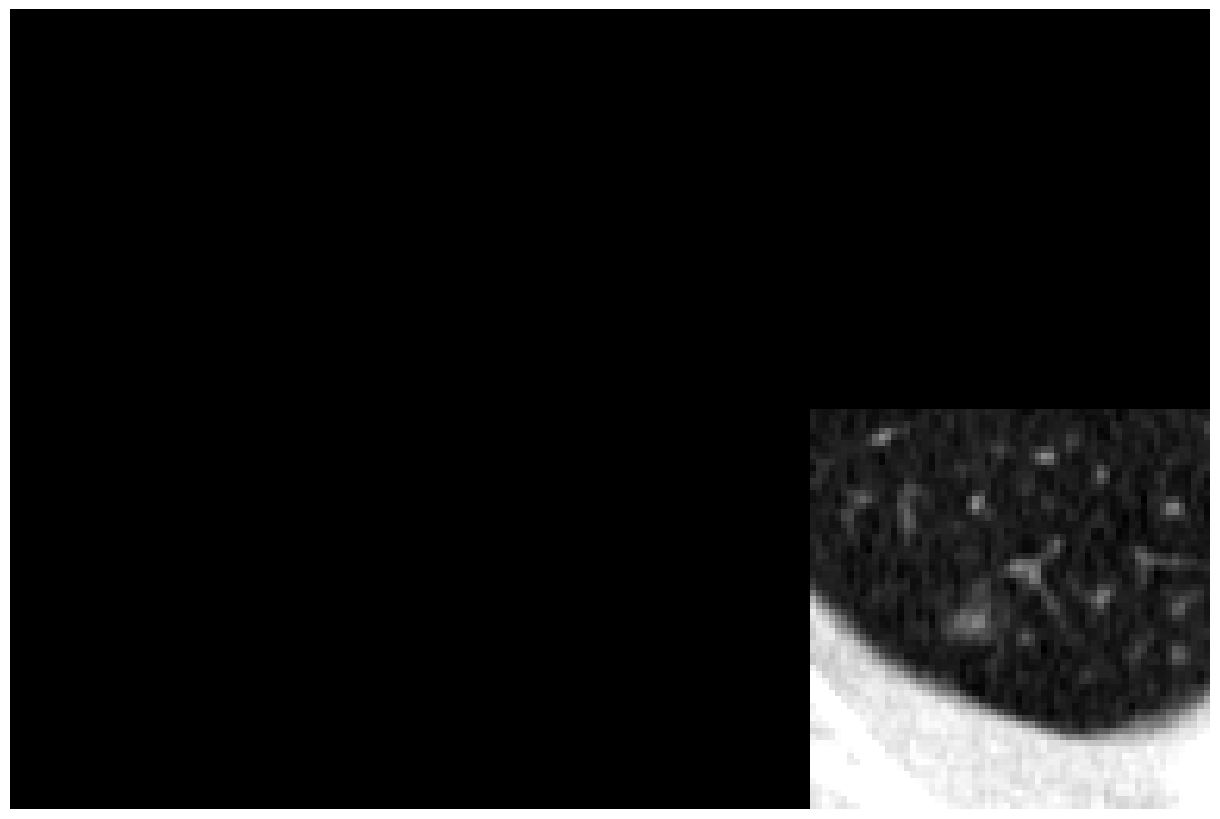

0 - 63.33%


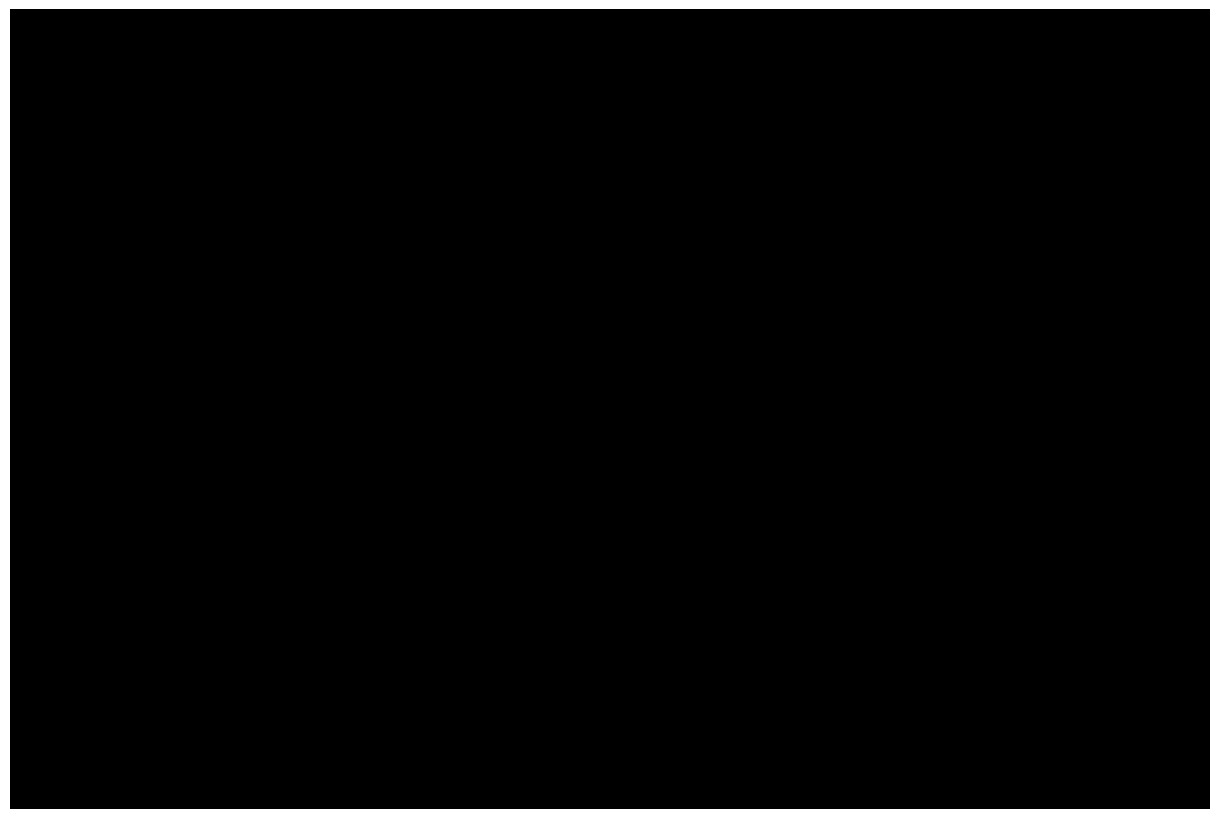

In [42]:
print(f'Ground truth: {img_label}')
plot_predictions(predictions_mean, imgs)

# Next step
Perform data augmentation